In [150]:
import skimage as sk
import matplotlib.pyplot as plt
from dottamine import dotim
import numpy as np
import cv2

In [383]:
image = sk.io.imread('./../ppujol/zmap/62_denoised time 3.tif')

In [384]:
image_r = np.transpose(image, axes=(1,0,2))
image_r = np.transpose(image_r, axes=(2, 1, 0))

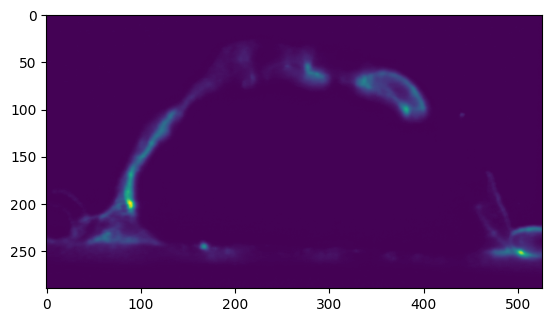

In [21]:
plt.imshow(image_r[300])

In [22]:
def normalize_image(im, mult_factor = 1):
    im = np.array(im)
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

In [25]:
doter = dotim(image_r, is2D=False, treat_3D_as_2D=False)
mask_r = doter.get_mask(times=3, binshape=(2,2,2), v='+')

Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


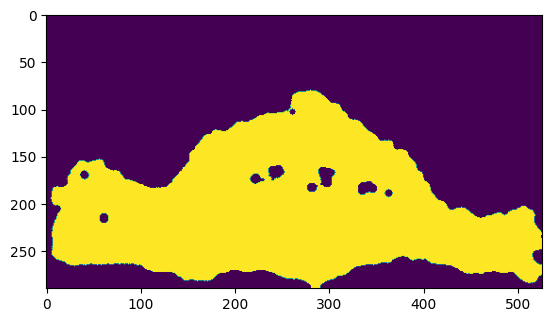

In [31]:
plt.imshow(mask_r[100])

In [27]:
mask_r2 = mask_r.astype(np.uint16)

In [28]:
import tifffile as tiff
# tiff.imwrite("./../ppujol/zmap/62 t3 mask.tif", mask_r2, imagej=True)

After doing the first mask, remove the found cells from the original image and try again dotamine or do CLAHE before in order to highlight the missing cells.

In [29]:
def clahe(image):
    flat_image = image.flatten()
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
    cl1 = clahe.apply(normalize_image(flat_image, 255).astype(np.uint8))
    clahe_image = cl1.reshape(image.shape)

    return clahe_image

clahe_image = clahe(image=image)

In [30]:
# tiff.imwrite("./../ppujol/zmap/62 t3 clahe.tif", clahe_image, imagej=True)

3D curvilinear interpolation

In [47]:
mask_r = sk.io.imread('./../ppujol/zmap/62 t3 mask.tif')

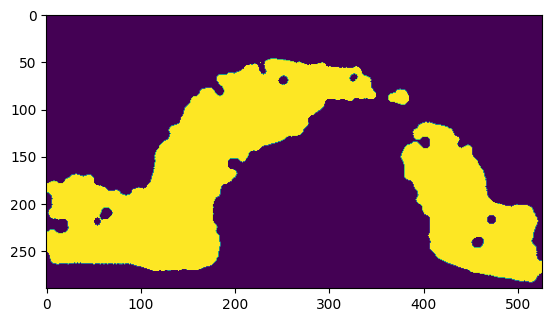

In [48]:
plt.imshow(mask_r[180])

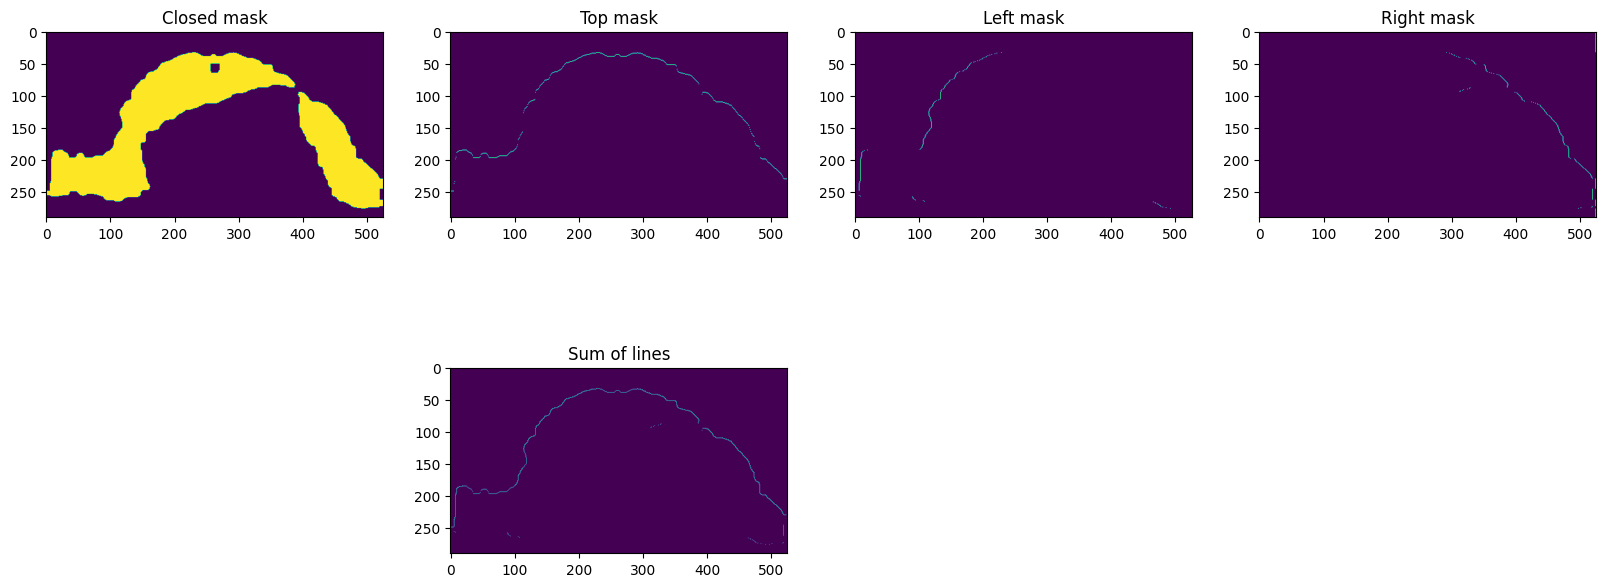

In [143]:
closed_mask_r = []
for i in mask_r:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((10, 10)))
    closed_mask_r.append(full)


closed_mask = np.array(closed_mask_r)

## Find the top line of the mask
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

## Find the left line of the mask
first_left_nonzero_indices = np.argmax(closed_mask != 0, axis=2)
left_mask = np.zeros_like(closed_mask)
left_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), first_left_nonzero_indices[None, :, None]] = 1 # Top mask is a 3D array that contains the left line of the actual mask

## Find the right line of the mask
last_right_nonzero_indices = closed_mask.shape[2] - np.argmax(closed_mask[:, :, ::-1] != 0, axis=2) - 1
right_mask = np.zeros_like(closed_mask)
right_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), last_right_nonzero_indices[None, :, None]] = 1 # Right mask is a 3D array that contains the right line of the actual mask

sum_mask = top_mask+left_mask+right_mask
sum_mask[0, :, :] = 0
sum_mask[-1, :, :] = 0
sum_mask[:, 0, :] = 0
sum_mask[:, -1, :] = 0
sum_mask[:, :, 0] = 0
sum_mask[:, :, -1] = 0


plt.figure(figsize=(20,8))
y = 220
plt.subplot(241)
plt.title('Closed mask')
plt.imshow(closed_mask[y])
plt.subplot(242)
plt.title('Top mask')
plt.imshow(top_mask[y])
plt.subplot(243)
plt.title('Left mask')
plt.imshow(left_mask[y])
plt.subplot(244)
plt.title('Right mask')
plt.imshow(right_mask[y])

plt.subplot(246)
plt.title('Sum of lines')
plt.imshow(sum_mask[y])

In [144]:
import tifffile as tiff
sum_mask = np.transpose(sum_mask, axes=(1,2,0))
tiff.imwrite("./../ppujol/zmap/62 t3 sum lines.tif", sum_mask, imagej=True)

In [430]:
sum_mask = sk.io.imread("./../ppujol/zmap/62 t3 sum lines.tif")

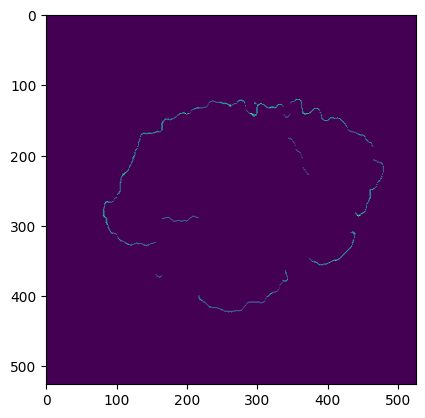

In [431]:
plt.imshow(sum_mask[100])

In [405]:
sum_mask_r = np.transpose(sum_mask, axes=(1,0,2))
sum_mask_r = np.transpose(sum_mask_r, axes=(2, 1, 0))

In [401]:
hull = []

for i in sum_mask:
    hull.append(sk.morphology.convex_hull_image(i))

hull = np.array(hull)
hull = hull.astype(np.uint8)

/tmp/ipykernel_169119/546418270.py:4: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull.append(sk.morphology.convex_hull_image(i))


In [185]:
# hull = np.transpose(hull, axes=(1,0,2))
# hull = np.transpose(hull, axes=(2, 1, 0))


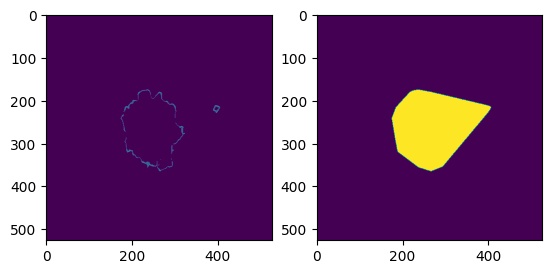

In [402]:
hull_2 = hull[:, :, :]

plt.figure()
plt.subplot(121)
plt.imshow(sum_mask[50])
plt.subplot(122)
plt.imshow(hull_2[50])

In [215]:
tiff.imwrite("./../ppujol/zmap/62 t3 hull.tif", hull_2, imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t3 sum lines.tif", sum_mask, imagej=True)

Get the points that represent the surface of the hull:

In [381]:
volume = sk.io.imread("./../ppujol/zmap/62 t3 hull.tif")

In [281]:
def find_points(volume):

    # Pad the volume with zeros on all sides to handle edge cases
    padded_volume = np.pad(volume, 1, mode='constant', constant_values=0)

    # Use np.where to find points with value 1 and neighbors with value 0
    result_indices = np.where(
        (padded_volume[1:-1, 1:-1, 1:-1] == 1) & 
        ((padded_volume[:-2, 1:-1, 1:-1] == 0) |
        (padded_volume[2:, 1:-1, 1:-1] == 0) |
        (padded_volume[1:-1, :-2, 1:-1] == 0) |
        (padded_volume[1:-1, 2:, 1:-1] == 0) |
        (padded_volume[1:-1, 1:-1, :-2] == 0) |
        (padded_volume[1:-1, 1:-1, 2:] == 0))
    )

    # Adjust indices to original volume coordinates
    result_points = [(z, y, x) for z, y, x in set(zip(*result_indices))]
    result_points = np.array(result_points)

    return result_points

In [282]:
result_points = find_points(volume=volume)

surface = np.zeros(volume.shape)

for i in result_points:
    z = i[0]-1
    y = i[1]-1
    x = i[2]-1
    surface[z,y,x] = 1

surface = surface.astype(np.uint16)

In [253]:
tiff.imwrite("./../ppujol/zmap/62 t3 hull surface.tif", surface, imagej=True)

Now we have a hull mask of the dome. We should use it to find the brigthest point around.

First do it VERTICALLY

In [ ]:
volume_r = np.transpose(volume, axes=(1,0,2))
volume_r = np.transpose(volume_r, axes=(2, 1, 0))

In [413]:

def first_nonzero(volume_r):


    first_nonzero_indices = np.argmax(volume_r != 0, axis=1)

    ## Move up or down the line
    first_nonzero_indices = first_nonzero_indices # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher, useful for apical.
    first_nonzero_indices[first_nonzero_indices < 0] = 0
    first_nonzero_indices[first_nonzero_indices >= volume_r.shape[1]] = volume_r.shape[1]-1
    ## Fi move up or down the line

    top_mask_r = np.zeros_like(volume_r)
    top_mask_r[np.arange(volume_r.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(volume_r.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask
    top_mask_r[:,0,:] = 0

    return top_mask_r

top_mask_r = first_nonzero(volume_r)


In [360]:
top_mask = np.transpose(top_mask_r, axes=(1,2,0))

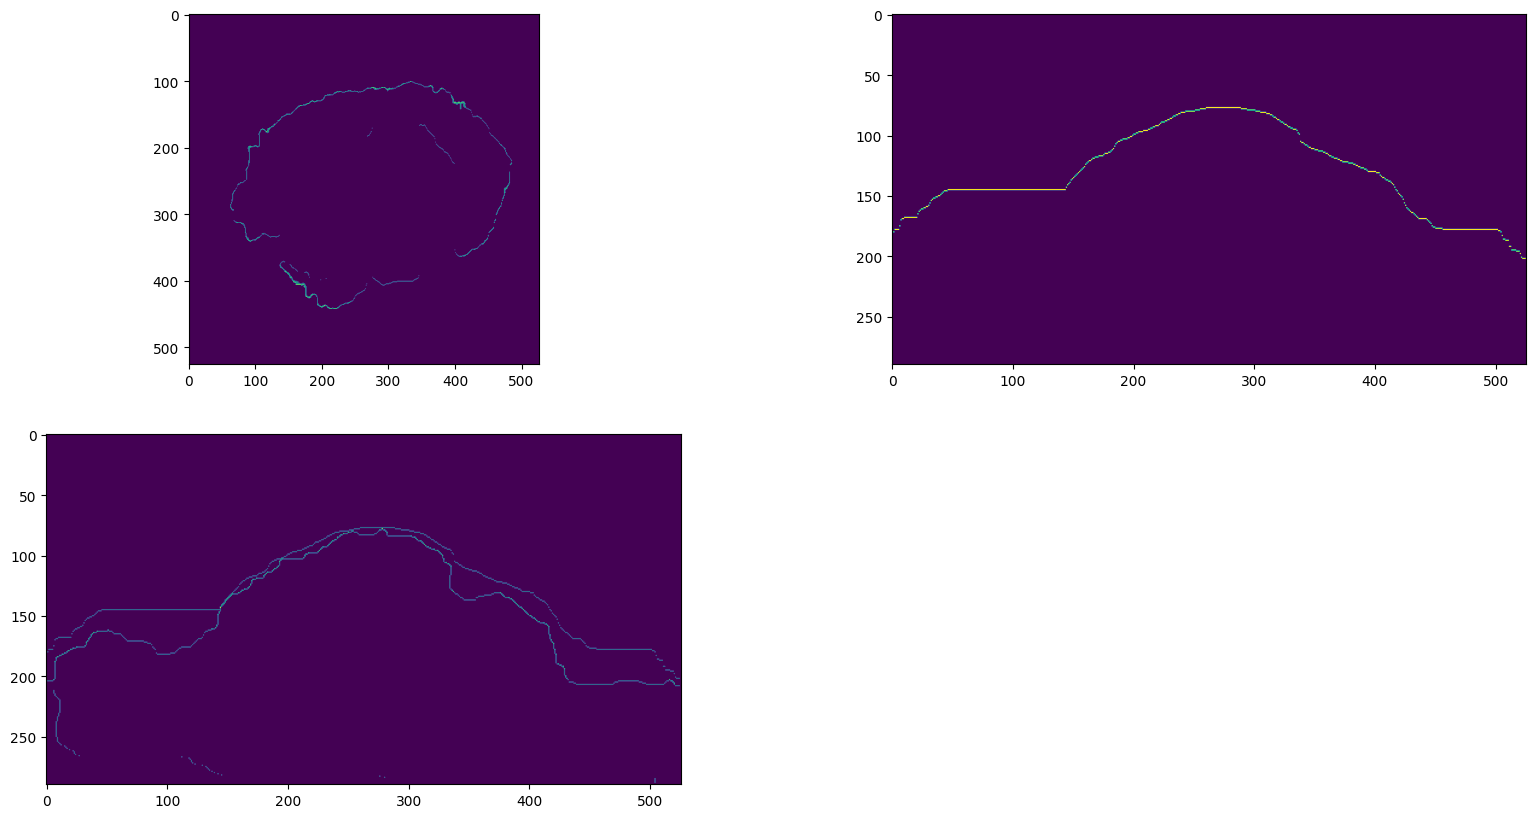

In [415]:
y = 120
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(sum_mask_r[y])
plt.subplot(222)
plt.imshow(top_mask_r[y])
plt.subplot(223)
plt.imshow(sum_mask_r[y] + top_mask_r[y])


In [366]:
from scipy.ndimage import gaussian_filter


top_mask = top_mask.astype(np.float64)

filtered = gaussian_filter(top_mask, 20)
epithelial = filtered*image

In [416]:
sum_mask = sum_mask.astype(np.float64)
filtered_sum = gaussian_filter(sum_mask, 20)
epithelial_sum = filtered_sum*image

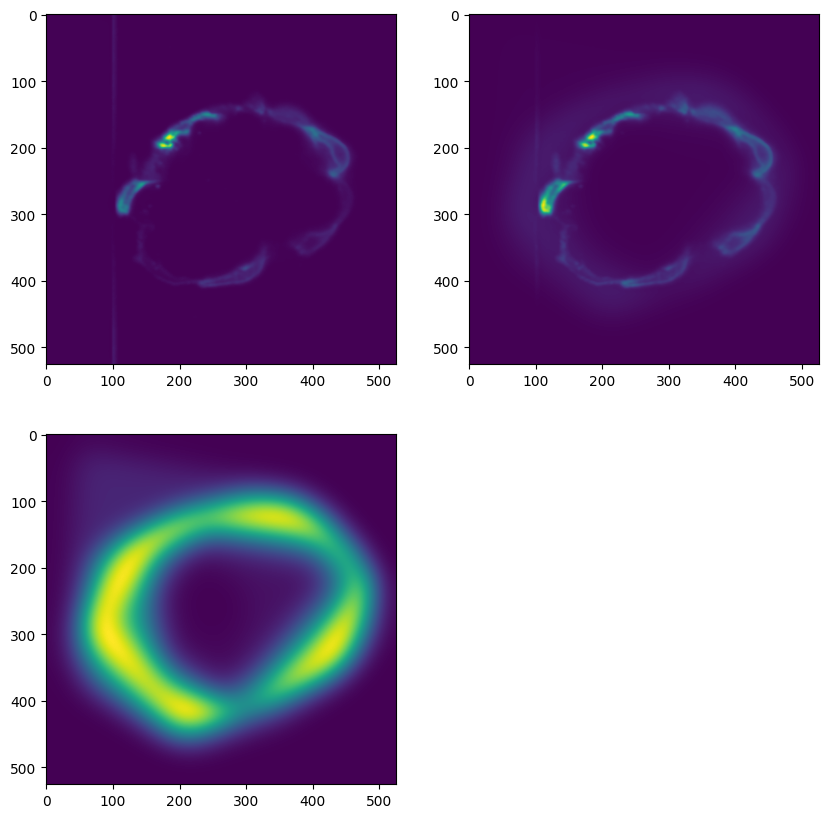

In [418]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(image[100])
plt.subplot(222)
plt.imshow(epithelial[100])
plt.subplot(223)
plt.imshow(filtered[100])

In [434]:
epithelial_r = np.transpose(epithelial, axes=(1,0,2))
epithelial_r = np.transpose(epithelial_r, axes=(2, 1, 0))

epithelial_sum_r = np.transpose(epithelial_sum, axes=(1,0,2))
epithelial_sum_r = np.transpose(epithelial_sum_r, axes=(2, 1, 0))

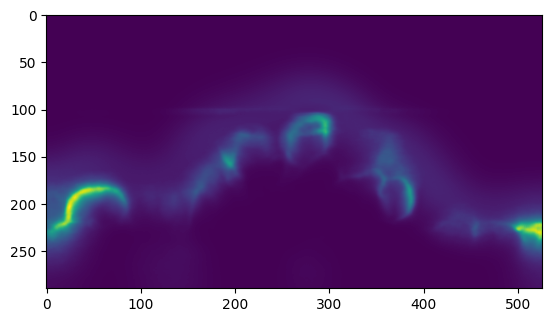

In [435]:
plt.imshow(epithelial_sum_r[100])

In [436]:
max_intensity_indices = np.argmax(epithelial_r, axis=1)
max_intensity_values = np.max(epithelial_r, axis=1)

In [437]:
max_intensity_indices_sum = np.argmax(epithelial_sum_r, axis=1)
max_intensity_values_sum = np.max(epithelial_sum_r, axis=1)

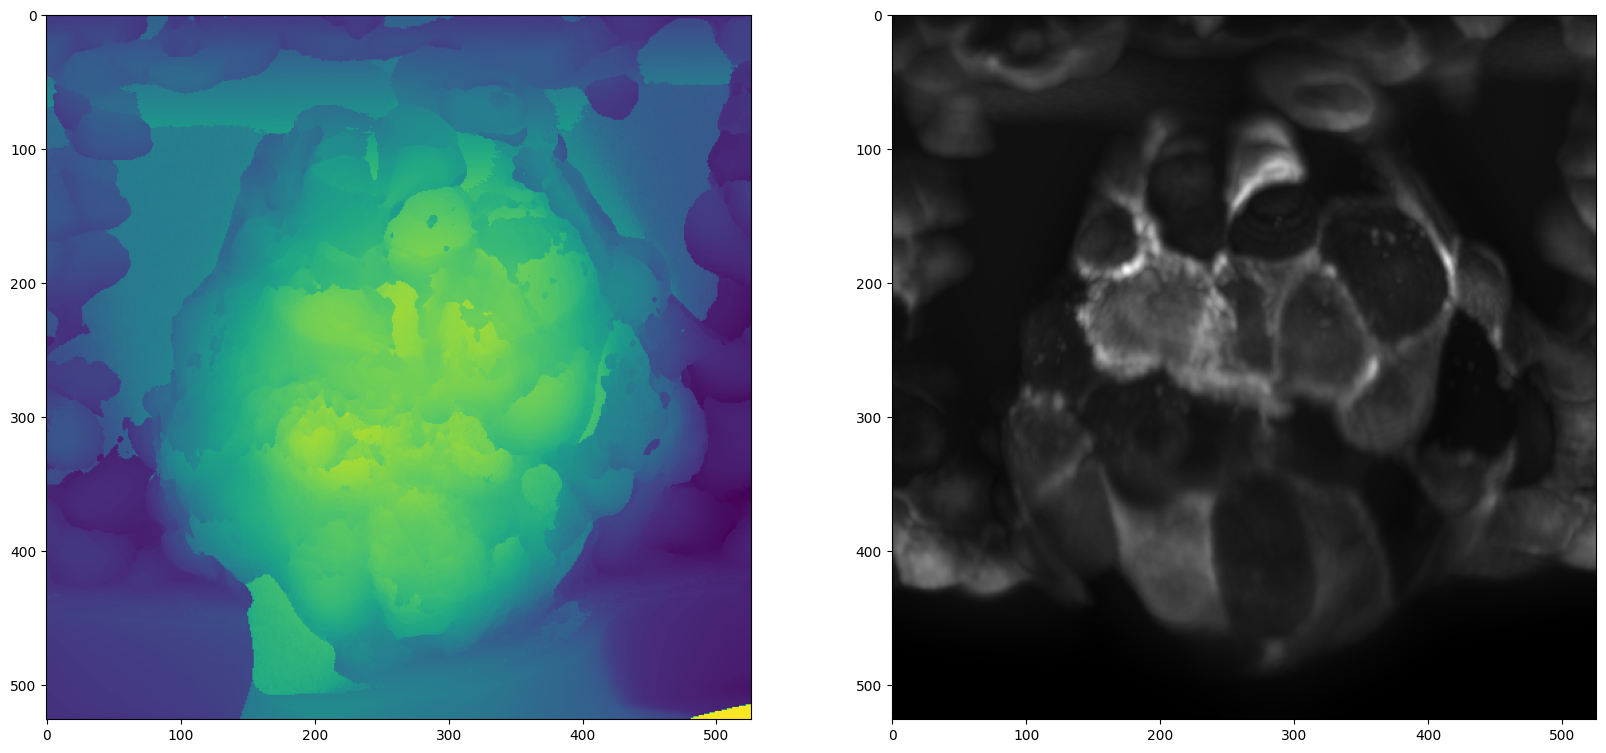

In [438]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(max_intensity_indices.max()-max_intensity_indices)
plt.subplot(122)
plt.imshow(max_intensity_values, cmap='gray')

In [439]:
tiff.imwrite("./../ppujol/zmap/62 t3 hull z height map.tif", normalize_image(max_intensity_indices, 65535).astype(np.uint16), imagej=True)

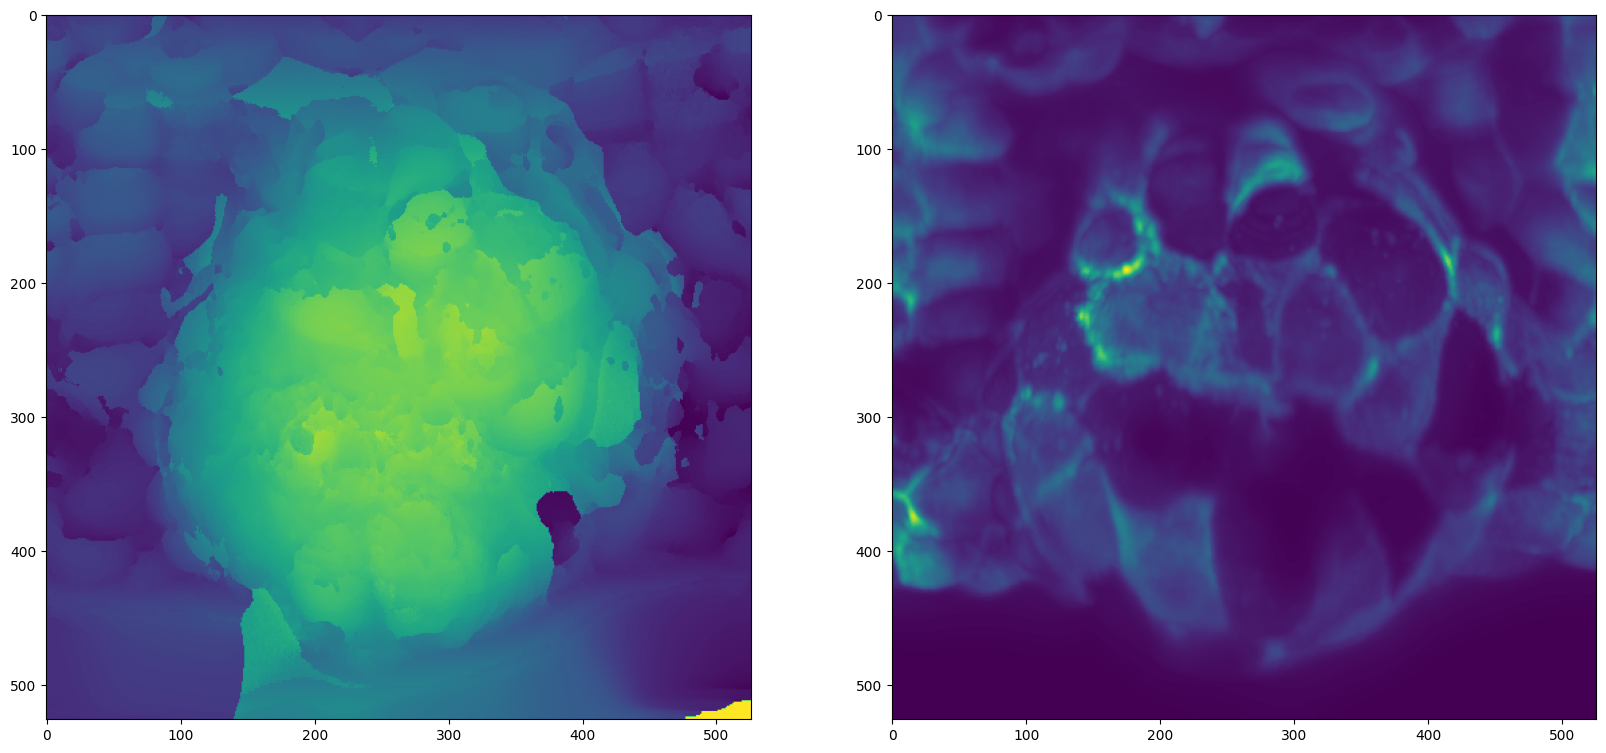

In [440]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(max_intensity_indices_sum.max()-max_intensity_indices_sum)
plt.subplot(122)
plt.imshow(max_intensity_values_sum)

In [441]:
tiff.imwrite("./../ppujol/zmap/62 t3 hull z height map sum lines.tif", normalize_image(max_intensity_indices_sum, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t3 hull z map sum lines.tif", normalize_image(max_intensity_values_sum, 65535).astype(np.uint16), imagej=True)

END 